# Predicting when a company will send it's next marketing email

This project aims to predict when a company will send it's next marketing email. The data comes from [MailCharts](https://www.mailcharts.com/).

Predicting when your competitors will send their next marketing blast allows you to get ahead of the game and send your email before they do.

- Sample data: http://share.mailcharts.com/0b141Z3c1M40
- All data: _coming soon_

In [229]:
# Import libraries and dependencies

from datetime import date, datetime
import pandas as pd
import numpy as np
import re
import scipy
import seaborn as sns
import timeit

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split 
from xgboost import XGBRegressor, plot_tree

from sklearn.grid_search import GridSearchCV

In [350]:
# Import the data

df = pd.read_csv('./data/2017-12-capstone.csv')
# df = pd.read_csv('./data/capstone-sample.csv')
df.shape

(39864, 6)

In [351]:
# Add first set of features we need

df['sent_time'] = pd.to_datetime(df.sent_at)
df['hour'] = df.sent_time.apply(lambda x: x.hour)
df['day'] = df.sent_time.apply(lambda x: x.day)
df['month'] = df.sent_time.apply(lambda x: x.month)
df['year'] = df.sent_time.apply(lambda x: x.year)
df['day_of_week'] = df.sent_time.dt.weekday_name 
df['day_of_week_num'] = df.sent_time.dt.weekday 
df['weekend'] = df.day_of_week.apply(lambda x: 1 if x=='Saturday' or x=='Sunday' else  0) 
df["weeknum"] = df.sent_time.dt.weekofyear
df["am_pm"] = df.sent_time.apply(lambda x: 1 if x.strftime('%p') == "AM" else 0)

In [352]:
df = df.sort_values("sent_at", ascending=True)

results = []
companies = df["company_id"].unique()

for c in companies:
    company_emails = df[df["company_id"] == c]
    previous_email_sent_at = None

    for index, row in company_emails.iterrows():
        if previous_email_sent_at == None:    
            previous_email_sent_at = row["sent_at"]
            df.loc[index, "prev_email"] = 0
        else:
            df.loc[index, "prev_email"] = previous_email_sent_at
            previous_email_sent_at = row["sent_at"]

In [353]:
# Get the time delta from when the previous email was sent

def construct_full_date(timestamp):
    # 2017-01-01 00:01:32
    # format: year, month, day, hour, minute, seconds
    date = re.split(" |\-|\:", timestamp)
    _date = [int(x) for x in date]
    return datetime(year=_date[0], month=_date[1], day=_date[2], hour=_date[3], minute=_date[4], second=_date[5])

def get_time_delta(a, b):
    if b == 0:
        return 0
    else:
        return (construct_full_date(a) - construct_full_date(b)).total_seconds()
    
df["delta_in_seconds"] = df.apply(lambda x: get_time_delta(x["sent_at"], x["prev_email"]), axis=1)

In [354]:
# QA that we only have 1 time_delta with a value of 0

df[df["delta_in_seconds"] == 0]["company_name"].value_counts()

Victoria's Secret               2
Patagonia                       2
Segment                         2
Bloomingdale's                  2
Target                          2
Constant Contact                2
Wine Library                    2
Pluralsight                     2
Williams Sonoma                 2
Detroit Pistons Store           2
Bigstock                        2
Nike                            2
GUESS                           1
Thrive Market                   1
Thomas Pink                     1
J.Crew                          1
WinMagic                        1
Bleacher Report                 1
Chegg                           1
David's Bridal                  1
Walmart                         1
Reformation                     1
Baxter International            1
Ashley HomeStore                1
NFL                             1
ivivva                          1
BarkBox                         1
Groupon                         1
Intercom.io                     1
Medium        

In [355]:
# Add a few more features which will make it easier to read our time deltas

df["delta_in_hours"] = df["delta_in_seconds"] / 60 / 60
df["delta_in_days"] = df["delta_in_seconds"] / 60 / 60 / 24

In [356]:
# Get company dummies. This will help us calculate each prediction at a company level

dummy_company = pd.get_dummies(df["company_name"])
dummy_company.head()

# Merge both dataframes

df = pd.merge(df, dummy_company, right_index=True, left_index=True)

In [357]:
sub_df = df.loc[df["company_name"].isin(["JackThreads", "Patagonia", "Bloomingdale's", "Target", "Segment", "Williams Sonoma", "1-800-Flowers.com", "Seamless", "Kidbox"])]

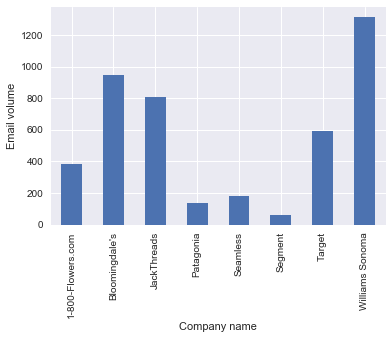

In [358]:
# Visualize  send volume to understand the data a bit better
# Takeaway #1: Email volume varies drastically by company.

email_counts_sum = sub_df.groupby(["company_name"])["delta_in_seconds"].count()
bars = email_counts_sum.plot(kind='bar')
bars.set_ylabel("Email volume")
bars.set_xlabel("Company name")

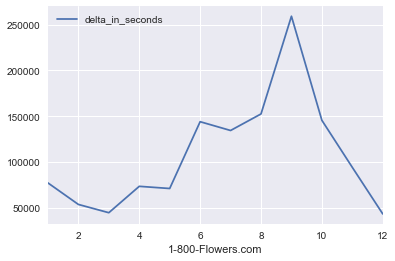

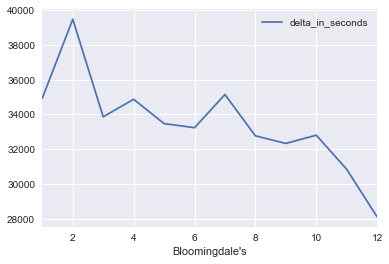

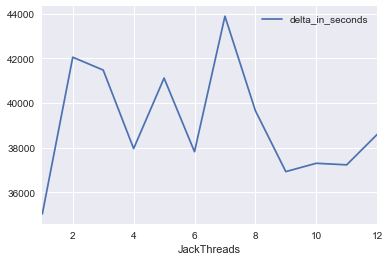

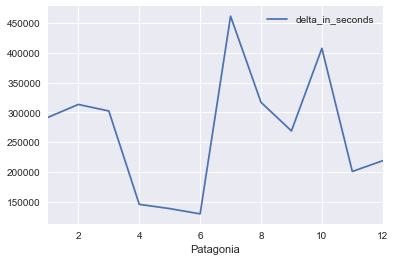

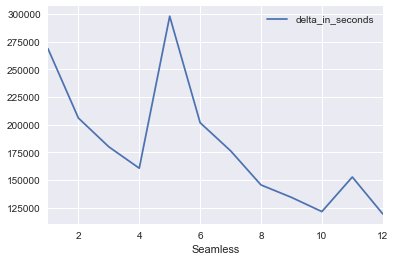

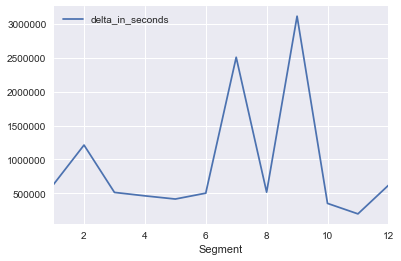

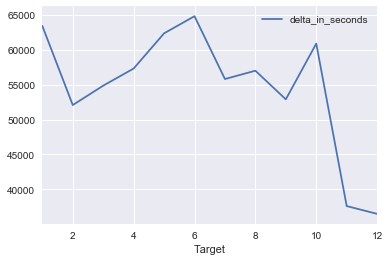

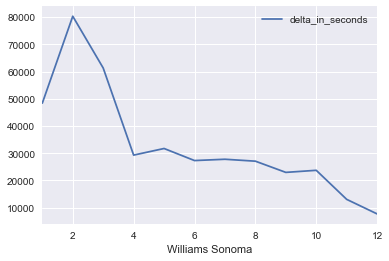

In [359]:
# Let's analyze the sending behavior of a few companies
# Takeaway #2: Every company has their own sending behavior throughout the year!
# Takeaway #3: Seasonality is likely to impact email frequency.
# Note: Spikes == more time in between emails

time_delta_average_by_month = sub_df.groupby(by=['company_name', 'month'])["delta_in_seconds"].mean().reset_index()
c_name = time_delta_average_by_month["company_name"].unique()

for i in c_name:
    company = time_delta_average_by_month[time_delta_average_by_month["company_name"] == i].reset_index()
    plot = company.plot(x="month", y="delta_in_seconds")
    plot.set_xlabel(i)


In [360]:
# It's not 100% clear here, but it looks like industry could be a helpful feature to include in our model
# Let's visualize this

sub_df.groupby(["industry_name"]).delta_in_seconds.mean().astype(int).reset_index().sort_values("delta_in_seconds")

,industry_name,delta_in_seconds
1,other,22359
2,retail,44161
3,security & investigations,52949
0,consumer services,168682
4,sporting goods,228070


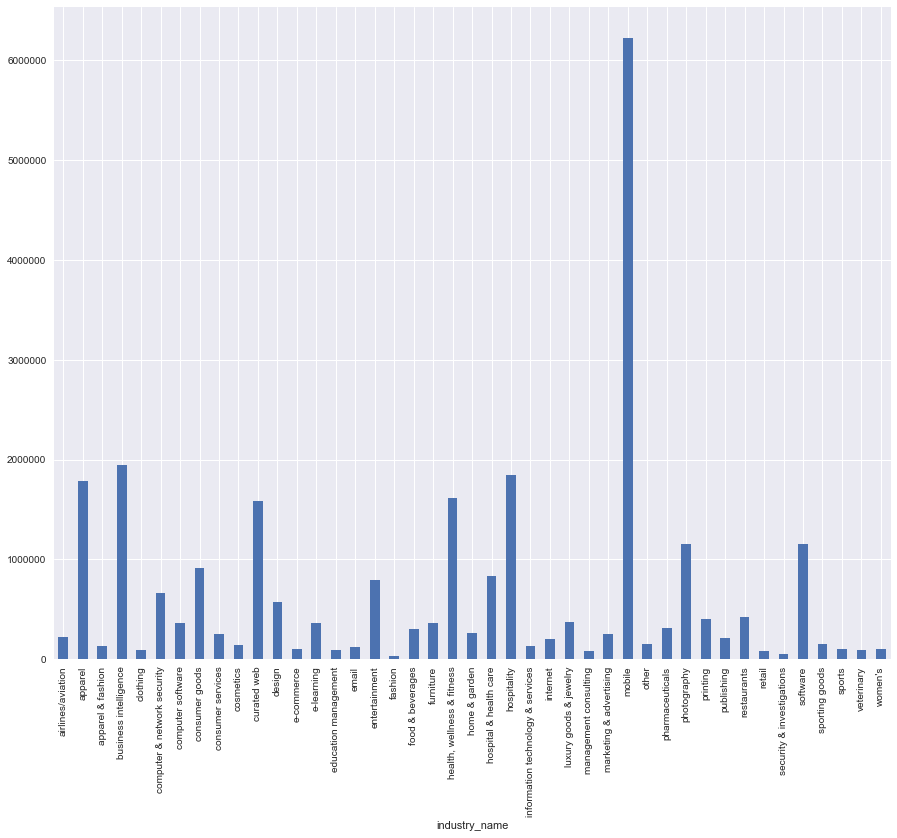

In [361]:
# Visualize the send volume to understand the data a bit better
# Takeaway #4: Consider adding industry as a feature

f = plt.figure(1, figsize = (15,12))
email_between_time_avg = df.groupby(["industry_name"]).delta_in_seconds.mean()
email_between_time_avg.plot(kind='bar')

plt.show()

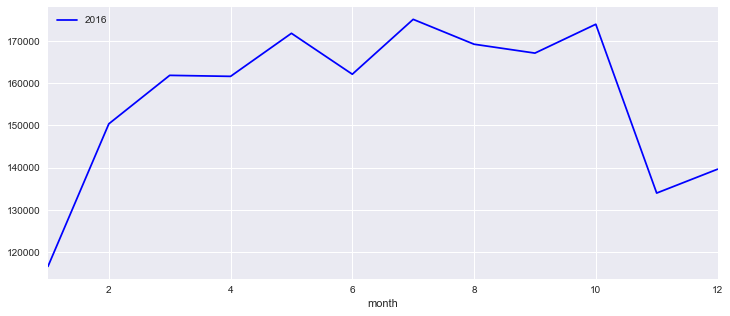

In [362]:
# Let's analyze all of the data by month to have a better look at seasonality

plt.figure(figsize=(12,5))
plt.xlabel('Time between two emails')

df.groupby("month").delta_in_seconds.mean().plot(color='blue', label='2016')

h1, l1 = ax1.get_legend_handles_labels()
plt.legend(h1, l1, loc=2)
plt.show()

# We can see the impact of seasonality

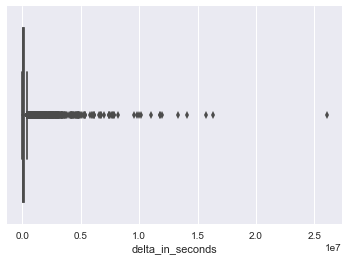

In [363]:
# Next, let's look at the distribution of our email delta

sns.boxplot(x=df["delta_in_seconds"])

# Look at that...! We have some outliers. Let's remove them.

(39864, 268)
(39489, 268)
We removed 375 outliers


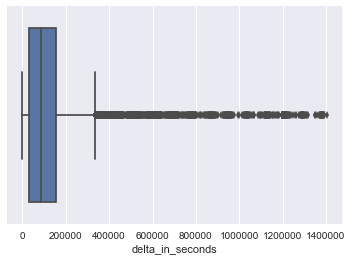

In [364]:
# Remove prev_time_delta outliers

stdev = df.delta_in_seconds.std()
mean = df.delta_in_seconds.mean()
upper_bound = mean + (stdev * 3)
lower_bound = mean - (stdev * 3)

non_outliers = df[(df.delta_in_seconds >= lower_bound) & (df.delta_in_seconds <= upper_bound)]

print(df.shape)
print(non_outliers.shape)
print("We removed", df.shape[0] - non_outliers.shape[0], "outliers")
sns.boxplot(x=non_outliers["delta_in_seconds"])

In [365]:
# This looks good, let's assign this back to our df variable

df = non_outliers

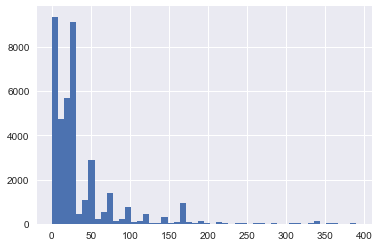

In [366]:
# Let's get a graps of how our data is distributed

df.delta_in_hours.hist(bins = 50)

# Look at that, it's left skewed.

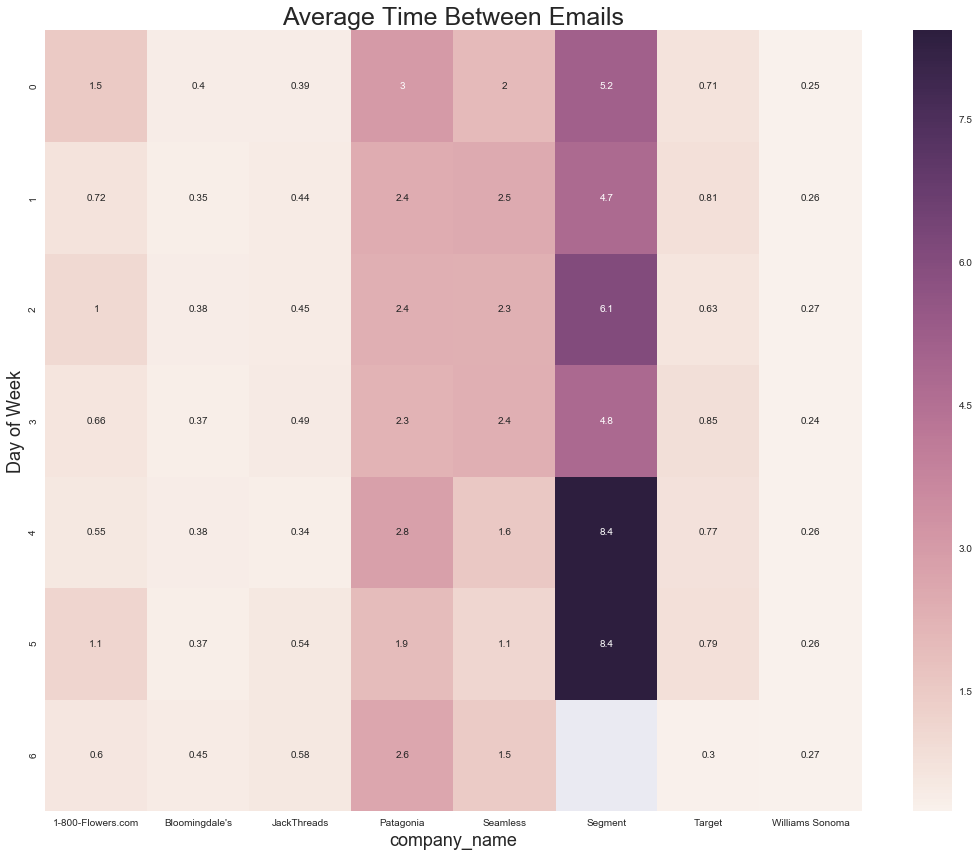

In [367]:
# Let's build a heatmap to better understand the impact of the day of the week.

f = plt.figure(1, figsize = (15,12))
pvt = pd.pivot_table(data=sub_df,values='delta_in_days',index='day_of_week_num', columns='company_name')
sns.heatmap(pvt, annot=True)

plt.title('Average Time Between Emails',fontsize=25)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('company_name',fontsize=18)
plt.ylabel('Day of Week',fontsize=18)
plt.tight_layout()

plt.show()

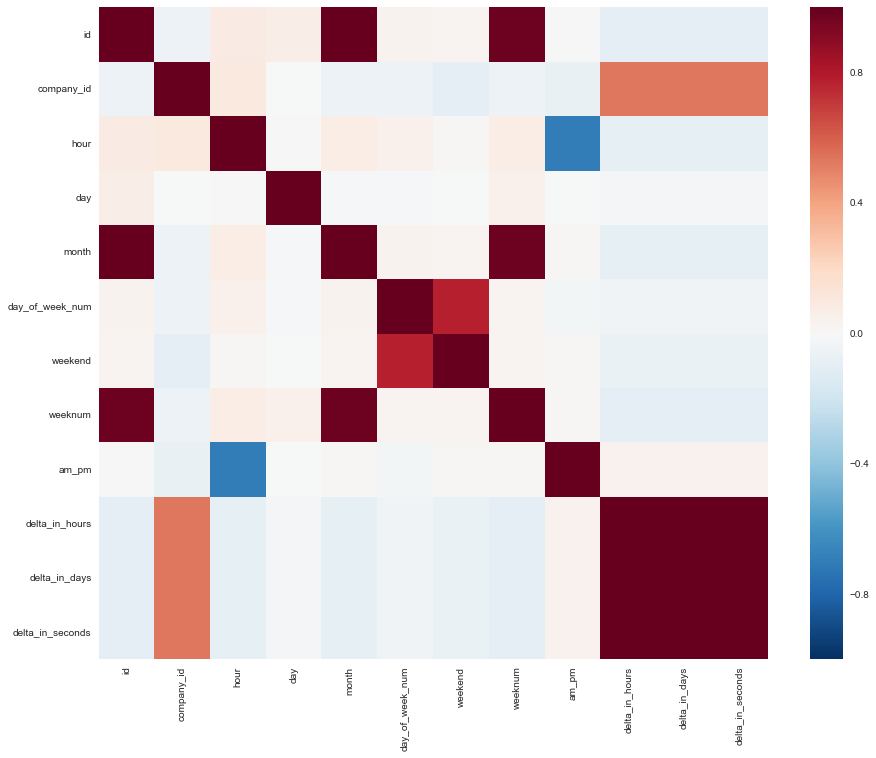

In [368]:
features_of_interest = ['id', 'company_name', 'company_id', 'subject', 'sent_at', 'industry_name', "sent_time", "hour", "day", 'month', 'day_of_week', 'day_of_week_num', 'weekend', 'weeknum', 'am_pm', 'delta_in_hours', 'delta_in_days', 'delta_in_seconds']

f = plt.figure(1, figsize = (15,12))
sns.heatmap(sub_df[features_of_interest].corr())
plt.show()

# day_of_week_num and weekend are correlated, let's not include both of these when building our models
# same with delta_in_<timeframe> — let's only pick one of the three

In [369]:
# Let's analyze seasonality

def season_map(month):
    season=''
    if month <=3:
        season='Winter'
    elif month<=6:
        season='Spring'
    elif month<=9:
        season='Summer'
    else: 
        season='Fall'
    return season

df['season'] = df.month.apply(lambda x:season_map(x))
df['season_num'] = pd.Categorical(df.season).codes

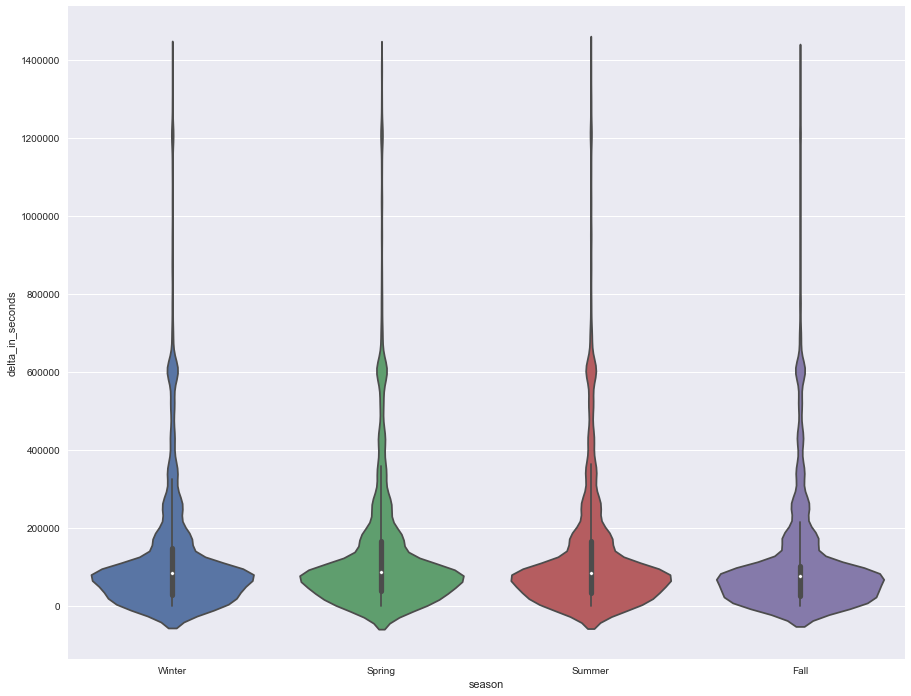

In [370]:
# There is no big difference across the different seasons

f = plt.figure(1, figsize = (15,12))
sns.violinplot(x='season', y='delta_in_seconds', data=df)
plt.show()

## Done with EDA. The modeling begins!

Features we want:

- Month
- Company
- Industry(?)
- Season? (Month can help with this though)

In [371]:
# for c in df.columns:
#    print(c)

In [372]:
# Convert industry name to codes
df['industry_num'] = pd.Categorical(df.industry_name).codes

In [373]:
target = df.delta_in_seconds
companies = df["company_name"].unique()
features_of_interest = np.append([companies], ['month', 'industry_num'])
features = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29616, 250)
(29616,)
(9873, 250)
(9873,)


In [374]:
# Naive prediction: Our benchmark
# TODO: Could we get a benchmark without using any models?
# Get a company's average time_delta for the training group. Compare it against the expected values for the test group.
# But now that I think about it we need some form of model to run this through...!

# benchmark_company = "Segment"
# benchmark_mean = df[df[benchmark_company] == 1].delta_in_hours.mean()

# abs(y_test[X_test[benchmark_company]==1 ]- gbr.predict(X_test[X_test[benchmark_company]==1])).mean()
# abs(y_test[X_test[benchmark_company]==1 ]-  benchmark_mean).mean()

In [375]:
# Initialize our fit our model, Linear Regression.

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [376]:
#y_pred = lr.predict(X_test)
lr.score(X_test, y_test)

# 50 is not that great. Let's see what we can do to improve this.

0.50931677853506452

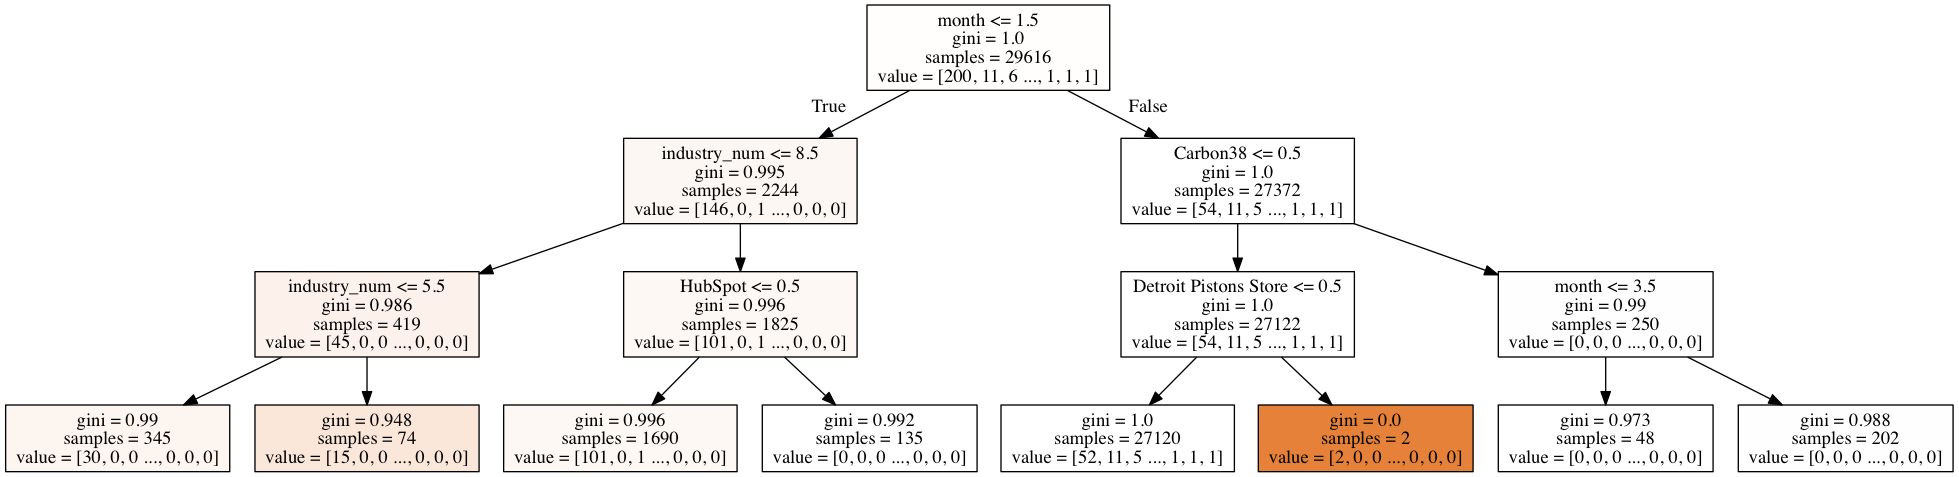

In [377]:
# Let's look at a decision tree to see if we can undestand how our data gets classified

from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

decision_tree = tree.DecisionTreeClassifier(max_depth=3)
decision_tree.fit(X_train, y_train)

dot_data = tree.export_graphviz(
    decision_tree,
    out_file=None,
    feature_names=features_of_interest,
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [378]:
print(decision_tree.score(X_test, y_test))
# These results are really bad. oy! There's not much we can learn from this.

0.00607718018839


In [379]:
# Perhaps a random using many trees can help improve the outcome? Let's try a random forrest

from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor(max_depth=3, random_state=100)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.10725421926


In [380]:
# We can get the score up to ~45, but now we risk overfitting with such a high depth
regr = RandomForestRegressor(max_depth=50, random_state=100)
regr.fit(X_train, y_train)
print(regr.score(X_test, y_test))

0.450453173286


In [381]:
# Let's try some fancier models

xgr=XGBRegressor()
xgr.fit(X_train, y_train) 
xgr.score(X_test, y_test) 

0.28074344974949561

In [382]:
adr = AdaBoostRegressor()
adr.fit(X_train, y_train)
adr.score(X_test, y_test)

-0.58576999866663404

In [383]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)

0.28632591906729865

In [384]:
# Let's revise our feature selection

In [385]:
# New features

df['subject_promo']=df.subject.str.contains('\%|\$|free')

In [386]:
target = df.delta_in_seconds
companies = df["company_name"].unique()
features_of_interest = np.append([companies], ['month', 'industry_num', 'am_pm', 'day_of_week_num', 'subject_promo'])
features = df[features_of_interest]

X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=100)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(29616, 253)
(29616,)
(9873, 253)
(9873,)


In [387]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5106083257502021

In [388]:
xgr.fit(X_train, y_train) 
xgr.score(X_test, y_test) 

0.288503538751819

In [389]:
adr.fit(X_train, y_train)
adr.score(X_test, y_test)

-0.62902180925582285

In [390]:
gbr.fit(X_train, y_train) 
gbr.score(X_test, y_test)

0.29528500959574

## Benchmark on average email in between time by company

In [391]:
#let's use GradientBoosting since it had the highest score above
gbr=GradientBoostingRegressor()
gbr.fit(X_train, y_train)
gbr.score(X_test, y_test)  

0.29528500959574011

In [392]:
companies = df["company_name"].unique()
companies

array(['Amazon', 'Blue Apron', 'Wine Library', 'NHL', 'Michaels Stores',
       'Thomas Pink', 'Udemy', 'A.C. Moore', 'Joann Stores',
       'La Roche-Posay', 'National Basketball Association', 'Athleta',
       "Kiehl's", 'NFL', 'Seamless', 'Little Pim', 'Rooms To Go',
       'Bassett Furniture Industries', 'Aritzia', 'JackThreads',
       'Pottery Barn', 'Express', 'Abercrombie & Fitch', 'Golf Town',
       'Medium', 'J.Crew', 'e.l.f. Cosmetics',
       'Century 21 Department Stores', 'Bluefly', "Victoria's Secret",
       'Aveda', 'Ashley HomeStore', 'GUESS', 'Bonobos', "Bloomingdale's",
       'HubSpot', 'JustFab', 'Walmart', 'JavaScript Weekly',
       'SkinCeuticals', 'Zappos', 'TOMS', 'DSW Shoe Warehouse',
       'Treehouse', 'Bumble and bumble.', 'Forever 21 USA',
       'Americaneagle.com', 'Net-A-Porter', 'Product Hunt', 'Gap',
       'Rent the Runway', 'Zocdoc', 'Michael Kors', 'BuyCostumes.com',
       'Target', 'Lush USA', 'iOS Dev Weekly', 'Thrive Market',
       'Criquet

In [393]:
def model_vs_benchmark(company):
    benchmark_mean = df[df[company] == 1].delta_in_hours.mean()
    # Our model error
    model_error = abs(y_test[X_test[company]==1 ]- gbr.predict(X_test[X_test[company]==1])).mean()
    # The benchmark error
    benchmark_error = abs(y_test[X_test[company]==1 ]-  benchmark_mean).mean()
    improvement = benchmark_error / model_error
    print("Model error: ", np.floor(model_error))
    print("Benchmark error: ", np.floor(benchmark_error))
    print("Improvement: ", np.round(improvement, 2), "x")
    return improvement

In [394]:
for c in companies:
    print("**", c, "**")
    model_vs_benchmark(c)
    print("====")

** Amazon **
Model error:  64554.0
Benchmark error:  54963.0
Improvement:  0.85 x
====
** Blue Apron **
Model error:  145871.0
Benchmark error:  265185.0
Improvement:  1.82 x
====
** Wine Library **
Model error:  44269.0
Benchmark error:  23174.0
Improvement:  0.52 x
====
** NHL **
Model error:  71919.0
Benchmark error:  115799.0
Improvement:  1.61 x
====
** Michaels Stores **
Model error:  23475.0
Benchmark error:  94570.0
Improvement:  4.03 x
====
** Thomas Pink **
Model error:  178133.0
Benchmark error:  306829.0
Improvement:  1.72 x
====
** Udemy **
Model error:  113156.0
Benchmark error:  100614.0
Improvement:  0.89 x
====
** A.C. Moore **
Model error:  62677.0
Benchmark error:  80351.0
Improvement:  1.28 x
====
** Joann Stores **
Model error:  28923.0
Benchmark error:  75450.0
Improvement:  2.61 x
====
** La Roche-Posay **
Model error:  73033.0
Benchmark error:  182058.0
Improvement:  2.49 x
====
** National Basketball Association **
Model error:  57975.0
Benchmark error:  66905.

ValueError: Found array with 0 sample(s) (shape=(0, 253)) while a minimum of 1 is required.